# DenseNet

Dense Convolutional Network (DenseNet) {cite}`huangDenselyConnectedConvolutional2018a`, introduced by Gao Huang and Kilian Weinberger of Cornell University,  Zhuang Liu of Tsinghua University, and Laurens van der Maaten of Facebook AI Research (FAIR) is among the most influential convolutional neural network (CNN) architectures of the past decade. With over 41,600 citations, the publication received Best Paper honors in the 2017 Conference on Computer Vision and Pattern Recognition (CVPR). 

## DenseNet Architecture
A typical convolutional neural network (CNN) architecture is comprised of one or more blocks of convolutional and pooling layers, fully connected layer(s), and an output layer that generates the predictions. 

```{figure} ../../figures/cnn.png
---
align: center
---
Traditional Convolutional Network
```

Each layer, generally speaking, takes feature maps from the previous layer, performs a convolution or pooling operation, and produces feature maps for the subsequent layer. For the $L$ layers in a CNN, there are typically $L$ connections – one between each layer and its subsequent layer.

As CNNs become deeper, and the number of layers increases, the problem of vanishing gradients becomes emergent. Vanishing gradients occur when the partial derivatives of the activation functions gradually diminish as they propagate back through the network.

In a DenseNet architecture, each layer is connected to every other layer, thereby increasing information flow through the network, strengthening feature propagation, and alleviating the vanishing gradient problem. 

Each layer $l$ in a DenseNet architecture receives $l$ inputs, consisting of concatenated feature maps from all preceding layers, and passes its feature maps to all $L-l$ subsequent layers. {numref}`densenet_blocks` illustrates the layout. 

```{figure} ../../figures/densenet_architecture.png
---
align: center
---
Densely Connected Convolutional Network
```

Hence a $L$ layer DenseNet has $\frac{L(L+1)}{2}$ connections. 

```{math}
:label: densenet_input
X_l=\mathcal{H}_l([x_0,x_1,…,x_{l-1}),
```

where $[x_0,x_1,…,x_{l-1}]$ refers to the concatenation of the feature maps produced in layers $0,…,l-1$.

The DenseNet architecture can be further described in terms of its dense blocks, transition layers, bottleneck layers, and growth rate.

### Dense Blocks

A DenseNet is comprised of four (4) dense blocks, each containing four composite functions. Each composite function performs three consecutive operations: batch normalization (BN), followed by a rectified linear unit (ReLU), then a 3 x 3 convolution (Conv) as shown in {numref}`densenet_dense_block`.

```{figure} ../../figures/densenet_composition.gif
---
align: center
---
DenseNet Composition Layer
```

Four sets of $k$ channel feature maps are generated, concatenated, and then passed on to a transition layer.

### Transition Layer

Between each dense block, transition layers perform the convolution and pooling operation, down-sampling the feature maps for subsequent dense blocks. 

```{figure} ../../figures/dense_blocks.png
---
align: center
---
Multiple Dense Blocks and Transition Layers
```

The transition layer consists of a batch normalization layer, a 1 x 1 convolutional layer, and a 2 x 2 average pooling layer.

### Bottleneck Layers

Bottleneck layers reduce the number of feature maps in the dense blocks and improve computational efficiency. A 1 x 1 convolution reduces the output channel dimensions before the 3 x 3 convolution in each block.

```{figure} ../../figures/densenet_bottleneck.png
---
align: center
---
Bottleneck Layers
```

The BN-ReLU-Conv(1x1)-BN-ReLU-Conv(3X3) above is referred to as the DenseNet-B Bottleneck Layer.

### Growth Rate

DenseNet layers are also very narrow, in that each layer contributes $k$ feature maps to the ‘collective knowledge’ of the network, while the remaining feature maps are kept unchanged. 
```{figure} ../../figures/densenet_growth.png
---
align: center
---
DenseNet Growth Rate
```
The hyperparameter $k$ is known as the *growth rate* of the network. It regulates how much new information each layer contributes to the global state. Once written, the global state can be accessed everywhere in the network; hence, no need to replicate it from layer to layer.

## DenseNet Architecture Benefits 
Several key benefits are derived from the DenseNet architecture.

### Parameter Efficiency: 
DenseNet can achieve SOTA performance matching that of ResNet with only 0.8M parameters, as compared to 10.2M parameters with ResNet. DenseNet250 with 15.3M parameters consistently outperforms models such as FractaNet and Wide ResNets that have more than 30M parameters.

### Computational Efficiency
```{figure} ../../figures/densenet_efficiency.png
---
align: center
---
DenseNet Computational Efficiency
```
The number of parameters in the ResNet model is directly proportional to the number of input and output feature maps:  C x C; whereas, the number of parameters in the DenseNet architecture is directly proportional to the number of layers and the growth rate as ($l$ x $k$ x $k$), where $k<<C$.

### Improved Gradient Flow
Each layer has direct access to the gradients from the loss function and to the original input signal, which helps with the training of deeper network architectures.

### Reduced Overfitting
Dense connections have a regularizing effect which reduces overfitting on tasks with smaller training sets.

### Implicit Deep Supervision:
A single DenseNet loss function performs deep supervision of all layers through at most two or three transition layers. 

```{figure} ../../figures/densenet_deep_supervision.png
---
align: center
---
Densely Connected Convolutional Network
```

### Diversified Features
Since each layer in DenseNet receives all the output from the preceding layers, it is exposed to a more diversified feature set which tends to present richer patterns. 

```{figure} ../../figures/densenet_diversified.png
---
align: center
---
Densely Connected Convolutional Network
```

### Low Complexity Features
In standard convolutional networks, classifiers make predictions based on the high complexity features of the top of the network. 

```{figure} ../../figures/densenet_std_feature_complexity.png
---
align: center
---
Traditional Convolutional Networks High Complexity Features
```
As a consequence of the dense connection architecture, DenseNet classifiers leverage the range of feature complexity levels when making predictions. 

```{figure} ../../figures/densenet_feature_complexity.png
---
align: center
---
DenseNet Full Range of Feature Complexity
```

In [1]:
import os
import wandb
import pathlib
import pandas as pd
import tensorflow as tf

from bcd.model.repo import ModelRepo
from bcd.model.factory import DenseNetFactory
from bcd.model.transfer import FineTuner
from bcd.model.callback import Historian
from bcd.model.schedule import LinearThawSchedule, LogThawSchedule, LinearLearningRateSchedule, LogLearningRateSchedule
pd.set_option('display.max_rows',999)


## Configuration

In [2]:
# W&B
%env "WANDB_NOTEBOOK_NAME" "01_densenet.ipynb"
project = "breast_cancer_detection"

# Model Parameters
full_dataset = True
model_name = "densenet" if full_dataset else "densenet_10"
version="v4_log"
name = f"{model_name}_{version}"
force = False  # Whether to retrain if the model and weights already exist from a prior training session.
metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
base_model_layer = 5 # Layer of the DenseNet base model
loss = "binary_crossentropy"
activation = "sigmoid"

# Dataset params
batch_size = 64 if full_dataset else 32
input_shape = (224,224,3)
output_shape = 1
train_dir = pathlib.Path("data/image/1_final/training/training/").with_suffix('') if full_dataset else pathlib.Path("data/image/1_final/training_10/training/").with_suffix('') 
test_dir = pathlib.Path("data/image/1_final/test/test/").with_suffix('')

# Feature Extraction Parameters
initial_epochs = 100  # Number of epochs to train for feature extraction
fe_learning_rate = 1e-4

# Fine Tune Parameters
fine_tune_epochs = 10  # Number of epochs for each fine tune session
fine_tune_sessions = 10 # Number of fine tune sessions
fine_tune_min_lr = 1e-7
fine_tune_max_lr = 1e-4


# Early stop parameters 
es_min_delta = 0.0001
es_monitor = "val_loss"  # Monitor validation loss for early stopping
es_patience = 8  # The number of consecutive epochs for which lack of improvement is tolerated 
es_restore_best_weights = True  # Returns the best weights rather than the weights at the last epoch.
es_verbose = 1
es_session_patience = None # The number of fine tuning sessions for which lack of improvement is tolerated. If None, no early stopping at session level

# Reduce LR on Plateau Parameters
rlr_monitor = "val_loss"
rlr_factor = 0.5
rlr_patience = 3
rlr_verbose = 1
rlr_mode = "auto"
rlr_min_delta = 0.0001
rlr_min_lr=1e-10

# ModelCheckpoint Callback parameters
mcp_location = "models/"
mcp_mode = "auto"
mcp_save_weights_only = False
mcp_save_best_only = True
mcp_save_freq = "epoch"
mcp_verbose = 1

# Historian parameters
filename = f"{name}_history.pkl"
historian_filepath = os.path.join("models", name, filename)



env: "WANDB_NOTEBOOK_NAME"="01_densenet.ipynb"


## Experiment Setup

In [3]:
config = {
    "architecture": "cnn",
    "model_name": model_name,
    "version": version,
    "dataset": "CBIS-DDSM-10",
    "batch_size": batch_size,
    "initial_epochs": initial_epochs,
    "fine_tune_epochs": fine_tune_epochs,
    "fine_tune_sessions": fine_tune_sessions,
    "fine_tune_min_lr": fine_tune_min_lr,
    "fine_tune_max_lr": fine_tune_max_lr,
    "early_stop_min_delta": es_min_delta,
    "early_stop_monitor": es_monitor,
    "early_stop_patience": es_patience,
    "early_stop_restore_best_weights": es_restore_best_weights,
    "early_stop_verbose": es_verbose,
    "rlr_monitor": rlr_monitor,
    "rlr_factor": rlr_factor,
    "rlr_patience": rlr_patience,
    "rlr_verbose": rlr_verbose,
    "rlr_mode": rlr_mode,
    "rlr_min_delta": rlr_min_delta,
    "rlr_min_lr": rlr_min_lr
    
}

In [4]:
run = wandb.init(project=project, config=config)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: aistudio. Use `wandb login --relogin` to force relogin


## Load Data

In [5]:
# Training DataSet (10%)
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    color_mode="rgb",
    image_size=(224,224),
    shuffle=True,
    validation_split=0.2,
    subset='training',
    interpolation="bilinear",
    seed=123,
    batch_size=batch_size)

# Validation DataSet (10%)
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    color_mode="rgb",
    image_size=(224,224),
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    interpolation="bilinear",
    seed=123,
    batch_size=batch_size)

# Test Set
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    color_mode="rgb",
    image_size=(224,224),
    shuffle=True)

Found 276 files belonging to 2 classes.
Using 221 files for training.
Found 276 files belonging to 2 classes.
Using 55 files for validation.
Found 649 files belonging to 2 classes.


## Dependencies
Several dependencies will be used throughout this notebook, including:
- Early Stop Callback
- Reduce Learning Rate on Plateau Callback
- Model Repository
- DenseNet Model Factory
- Historian Callback

We'll make those objects available here.

In [6]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor=es_monitor, 
                                                       min_delta=es_min_delta,
                                                       patience=es_patience, 
                                                       restore_best_weights=es_restore_best_weights,
                                                       verbose=es_verbose)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor=rlr_monitor,
                                                          factor=rlr_factor,
                                                          patience=rlr_patience,
                                                          verbose=rlr_verbose,
                                                          mode=rlr_mode,
                                                          min_delta=rlr_min_delta,
                                                          min_lr=rlr_min_lr)
wandb_callback = wandb.keras.WandbMetricsLogger()

repo = ModelRepo(location=mcp_location)

factory = DenseNetFactory()

historian = Historian(name=name)

linear_thaw_schedule = LinearThawSchedule(sessions=fine_tune_sessions, 
                                   base_model_layer=base_model_layer, 
                                   n_layers=len(factory.base_model.layers))

log_thaw_schedule = LogThawSchedule(sessions=fine_tune_sessions, 
                                   base_model_layer=base_model_layer, 
                                   n_layers=len(factory.base_model.layers))

linear_learning_rate_schedule = LinearLearningRateSchedule(sessions=fine_tune_sessions, initial_learning_rate=fine_tune_max_lr, final_learning_rate=fine_tune_min_lr)

log_learning_rate_schedule = LogLearningRateSchedule(sessions=fine_tune_sessions, initial_learning_rate=fine_tune_max_lr, final_learning_rate=fine_tune_min_lr)


## Feature Extraction
If the model already exists, obtain it from the repository. Otherwise, create the model and perform feature extraction.

In [7]:
stage = "feature_extraction"
if force or not repo.exists(name=name, stage=stage):
    model = factory.create(input_shape=input_shape, 
                            output_shape=output_shape,
                            activation=activation)
    # Create the optimizer
    optimizer=tf.keras.optimizers.Adam(learning_rate=fe_learning_rate)

    # Compile the Model
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=metrics,        
    )

    # Delete existing checkpoints
    repo.remove(name=name, stage=stage)
    # Summarize the model
    model.summary()
    # Obtain a checkpoint callback from the model repository 
    checkpoint_callback = repo.create_callback(name=name, stage=stage)
    # Set the session on the historian to 0 for feature extraction
    historian.on_session_begin(session=0)
    # Fit the model with callbacks
    history = model.fit(train_ds, 
                        validation_data=val_ds, 
                        epochs=initial_epochs, 
                        callbacks=[checkpoint_callback, 
                                   reduce_lr_callback,
                                   early_stop_callback, 
                                   wandb_callback,                                   
                                   historian])        
    # Register the model on wandb
    filepath = repo.get_filepath(name=name, stage=stage)    
    artifact = wandb.Artifact(f"{name}-{stage}-{run.id}", type="model")
    artifact.add_file(filepath)
    wandb.log_artifact(artifact, aliases=[stage, "best"])
    wandb.run.link_artifact(artifact, "aistudio/breast_cancer_detection/DenseNet")
else:
    # Obtain the model from the repository
    model = repo.get(name=name, stage=stage)
    # Obtain the historian
    historian = historian.load(historian_filepath)    
    # Summarize the model
    model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                             

2024-01-22 15:04:47.194884: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://e8eab0f9-4faa-46a5-ab1d-0a0d52704b9e/assets
INFO:tensorflow:Assets written to: ram://e8eab0f9-4faa-46a5-ab1d-0a0d52704b9e/assets


ArtifactManifestEntry(path='densenet_10_v4_log_feature_extraction_07-val_loss_0.60.keras', digest='uUYs3jmD00gch6vxUwldFg==', size=74489344, local_path='/home/john/.local/share/wandb/artifacts/staging/tmp81su055n')

<Artifact densenet_10_v4_log-feature_extraction-3hw2oxf8>

wandb: Waiting for artifact densenet_10_v4_log-feature_extraction-3hw2oxf8 to be committed...



wandb: Committed artifact aistudio/breast_cancer_detection/densenet_10_v4_log-feature_extraction-3hw2oxf8:v0


Feature extraction appears to have converged in fourteen epochs. Our early stopping callback stopped training when validation loss didn't improve in 3 epochs. Training and validation accuracy of 55% and 50% respectively, alludes to the considerable difference between source and target datasets. Gradually fine tuning the network on the CBIS-DDSM dataset will allow the network to adapt to the features and characteristics of our dataset.

The next cell will iteratively run a series of 10 fine tuning sessions in which the DenseNet model is gradually unfrozen in 10 increments. Each increment increases the number of layers to be thawed logarithmically from 1 layer to 707 layers of the DenseNet model. Learning rates will be decayed logarithmically from 1e-4 to 1e-10 to mitigate catastrophic forgetting within the network. 

Excellent. We can now move on to the fine tuning stage.

## Fine Tuning

Fine tuning has completed. Let's check the learning curves.

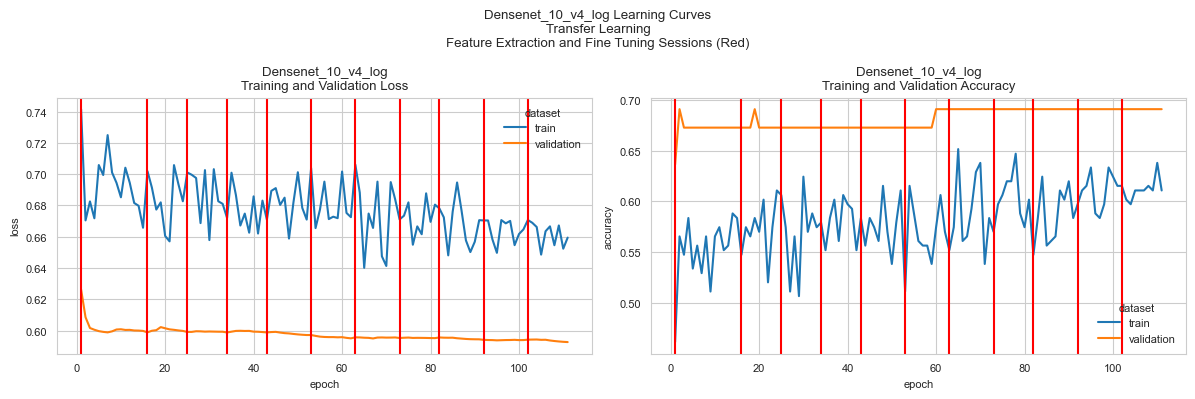

In [9]:
# Plot the historian
historian.plot_learning_curves()

## Evaluation
Let's evaluate generalization performance on the test set. 